In [6]:
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import sys
sys.path.append('/Users/liujiabo/backup/jiabo/gitHub/pyIRM/pyIRM')
from pyIRM import dataFit#,fit_plots
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [137]:
def fit_plots(ax,xfit,xraw,yfit,yraw,params=None,ycomponents=None):
    '''
    #====================================================================
    plot the fitted results for data fit and refit
    #====================================================================
    '''
    global _yfits_
    p = np.max(np.sum(yfit,axis=0))/sum(yraw)

    _yfits_ = yfit

    colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    if ycomponents !=None:
        for i,line in enumerate(ycomponents):
            mean = np.mean(line[1],axis=0)*p
            std = np.std(line[1],axis=0)*p
            x = xfit
            y1 = mean-std
            y2 = mean+std

            cm1 = LinearSegmentedColormap.from_list('Temperature Map', ['white',colors[i], 'white'])
            polygon = plt.fill_between(x, y2, y1, lw=1, color='none')
            verts = np.vstack([p.vertices for p in polygon.get_paths()])
            ymin, ymax = verts[:, 1].min(), verts[:, 1].max()
            gradient = plt.imshow(np.array([np.interp(np.linspace(ymin, ymax, 100), [y1i, y2i], np.arange(2))
                                            for y1i, y2i in zip(gaussian_filter(y1, 0, mode='nearest'),
                                                                gaussian_filter(y2, 0, mode='nearest'))]).T,
                                  cmap=cm1, aspect='auto', origin='lower', extent=[x.min(), x.max(), ymin, ymax],alpha=0.8)
            gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)

            for l in line[1]:
                plt.plot(xfit,l*p,lw=0.1,alpha=0.4,color='grey')

    for i in np.arange(yfit.shape[1]):
        if params != None:
            y = yfit[:,i]
            s = 'g'+str(i+1)+'_sigma'
            c = 'g'+str(i+1)+'_center'
            content=sum(y)/sum(np.sum(yfit,axis=1))*100
            label = str(int(content))+'%   '+ str('%.2f'%10**params[c].value)+' mT\n' +'dp='+str('%.2f'%params[s].value)
            ax.plot(xfit,y*p,label=label)
        else:
            ax.plot(xfit, yfit[:,i]*p)
    #print(np.sum(yfsum,axis=0))
    ax.plot(xfit, np.sum(yfit,axis=1)*p,color='grey')
    ax.scatter(xraw, yraw,color='k',facecolor='none',alpha=0.5)
    ax.set_xlabel('Field (log10(mT))')
    ax.set_ylabel('IRM normalization')
    ax.legend(frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


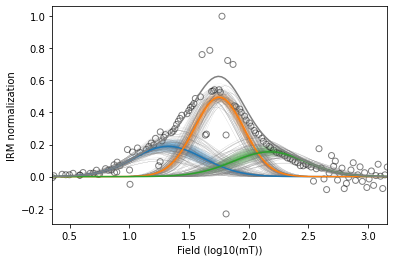

In [138]:
fitResult = dataFit(filePath='/Users/liujiabo/backup/jiabo/rockdata/ODP1233/IRM/B-11-2-99-101-IRM-1.5T.csv',fitNumber=3)

xfit=fitResult.fitDf['field']
xraw=fitResult.rawDf['field_log']
yfit=fitResult.pdf_best
yraw=fitResult.rawDf['rem_grad_norm']
ycomponents = fitResult.ycomponents

fig = plt.figure()
ax = fig.add_subplot(111)

fit_plots(ax,xfit,xraw,yfit,yraw,ycomponents=ycomponents)

plt.show()

In [121]:
fitResult.fitDf

,field,remanance,IRM_norm
0,0.355545,1.000000e-15,2.651620e-09
1,0.383879,1.000000e-15,2.651620e-09
2,0.412213,1.911704e-09,5.069113e-03
3,0.440547,3.768995e-09,9.993943e-03
4,0.468880,5.541885e-09,1.469497e-02
...,...,...,...
95,3.047262,1.000000e-15,2.651620e-09
96,3.075596,1.000000e-15,2.651620e-09
97,3.103930,1.000000e-15,2.651620e-09
98,3.132264,3.143366e-09,8.335013e-03


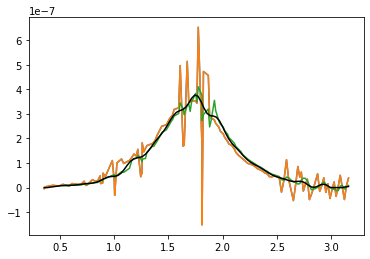

In [122]:
plt.plot(fitResult.rawDf['field_log'],np.gradient(fitResult.rawDf['remanance']))
plt.plot(fitResult.rawDf['field_log'],fitResult.rawDf['rem_gradient'])
plt.plot(fitResult.rawDf['field_log'],np.gradient(fitResult.rawDf['remanance'].rolling(5).mean()))

#y_gradient = np.interp(fitResult.rawDf['field_log'],np.log10(fitResult.rawDf['field']),np.gradient(fitResult.rawDf['remanance'].rolling(5).mean()))

#plt.plot(fitResult.rawDf['field_log'],y_gradient)
plt.plot(fitResult.fitDf['field'],fitResult.fitDf['remanance'],color='k')

In [139]:
from scipy import interpolate,spatial,signal

def loadData(filePath=None):
    '''
    #====================================================================
    in:
    read measured raw data file,
    search the line ['    Field       Remanence  '] in measured data file,
    skip all the rows above and the last line,
    otherwise, load data as two columns.
    #
    out:
    rawDf,fitDf are the pandas dataframe of measured raw data, and the
    log10 interploted data
    #====================================================================
    '''
    skip_3900_from = '    Field       Remanence  '
    skip_8600_form = '##DATA TABLE Moment (m)'
    with open(filePath,'rb') as fr:
        #f = fr.read()
        for i,line in enumerate(fr,1):
            #print(line)
            if skip_8600_form in str(line):
                skiprows=i+1
                coding='ISO-8859-15'
                names=['Step','Iteration','Segment','field','remanance',
                       'Time Stamp [s]','Field Status','Moment (m) Status']
                break
            elif skip_3900_from in str(line):
                skiprows=i+2
                coding='ISO-8859-15'
                names=['field','remanance']
                break
            else:
                skiprows=None
                coding='UTF-8'
                names=['field','remanance']
    #print('skiprows= ',skiprows)
    skiprows = skiprows if isinstance(skiprows,int) else 1
    rawDf = pd.read_csv(filePath, delimiter=',', names=names,
                        skiprows=skiprows, skipfooter=1,engine='python',
                        encoding=coding)
    rawDf = rawDf.astype({'field':float,'remanance':float})
    rawDf = rawDf[(rawDf['field']>0)]
    rawDf = rawDf.sort_values(by=['field'])
    rawDf['field'] = rawDf['field']*10**3 # mT to # T
    y_measure=rawDf['remanance']
    rawDf = rawDf[(rawDf['field']>=2)]
    rawDf['field_log'] = np.log10(rawDf['field'])
    rawDf['rem_gradient'] = np.gradient(rawDf['remanance'])
    rawDf['rem_grad_norm'] = rawDf['rem_gradient']/rawDf['rem_gradient'].max()
    field_fit = np.linspace(np.log10(rawDf['field'].min()),
                            np.log10(rawDf['field'].max()), 100)
    #y_gradient = interpolate.splev(field_fit,
    #                               interpolate.splrep(np.log10(rawDf['field']),
    #                               np.gradient(rawDf['remanance'])))
    b, a = signal.butter(5, 0.3)
    y_gradient = signal.filtfilt(b,a,np.interp(field_fit,np.log10(rawDf['field']),np.gradient(rawDf['remanance'].rolling(4, min_periods=1).mean())))
    fitDf = pd.DataFrame({'field':field_fit,'remanance':y_gradient})
    #fitDf['remanance'] = fitDf['remanance'].rolling(10, min_periods=1).mean()
    fitDf.remanance[fitDf.remanance<=0] = 10**-15
    return rawDf,fitDf


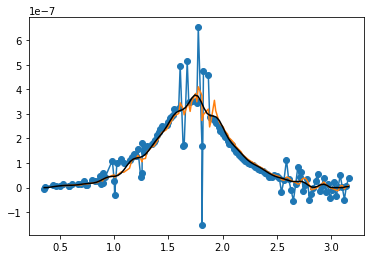

In [140]:
rawDf,fitDf = loadData(filePath='/Users/liujiabo/backup/jiabo/rockdata/ODP1233/IRM/B-11-2-99-101-IRM-1.5T.csv')
plt.scatter(rawDf['field_log'],np.gradient(rawDf['remanance']))
plt.plot(rawDf['field_log'],rawDf['rem_gradient'])
plt.plot(rawDf['field_log'],np.gradient(rawDf['remanance'].rolling(5).mean()))

#y_gradient = np.interp(fitResult.rawDf['field_log'],np.log10(fitResult.rawDf['field']),np.gradient(fitResult.rawDf['remanance'].rolling(5).mean()))

#plt.plot(fitResult.rawDf['field_log'],y_gradient)
plt.plot(fitDf['field'],fitDf['remanance'],color='k')

In [52]:

mean = np.mean(ycomponents[1][1],axis=0)
#means.append(mean)
std = np.std(ycomponents[1][1],axis=0)

In [7]:


x = xfit#np.linspace(0, 10, 200)
y1 = mean-std#np.random.normal(0.02, 1, 100).cumsum() + 20
y2 = mean+std#np.random.normal(0.05, 1, 100).cumsum() + 50
plt.plot(x,mean)

cm1 = LinearSegmentedColormap.from_list('Temperature Map', ['white','blue', 'white'])

polygon = plt.fill_between(x, y1, y2, lw=0, color='none')
ylim = plt.ylim()
verts = np.vstack([p.vertices for p in polygon.get_paths()])
ymin, ymax = verts[:, 1].min(), verts[:, 1].max()
#gradient = plt.imshow(np.array([np.interp(np.linspace(ymin, ymax, 400), [y1i, y2i], np.arange(2))
#                                for y1i, y2i in zip(y1, y2)]).T,
#                      cmap=cm1, aspect='auto', origin='lower', extent=[x.min(), x.max(), ymin, ymax])

gradient = plt.imshow(np.array([np.interp(np.linspace(ymin, ymax, 100), [y1i, y2i], np.arange(2))
                                for y1i, y2i in zip(gaussian_filter(y1, 2, mode='constant'),
                                                    gaussian_filter(y2, 2, mode='constant'))]).T,
                      cmap=cm1, aspect='auto', origin='lower', extent=[x.min(), x.max(), y1.min(), y2.max()])
#gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)
plt.ylim(ylim)
plt.show()

In [8]:
plt.fill_between(x, y1, y2)

In [9]:
fitResult.df.distance

AttributeError: 'dataFit' object has no attribute 'df'

In [10]:
allfits = fitResult.df['yfits']
allfits.values[0]

AttributeError: 'dataFit' object has no attribute 'df'

In [10]:
plt.plot(xfit,allfits.values[0][:,0])

NameError: name 'allfits' is not defined

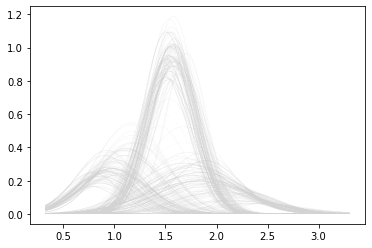

In [83]:
plt.figure()
for line in allfits:
    #print(len(line[0]))
    for i in np.arange(len(line[0])):
        plt.plot(xfit,line[:,i],lw=0.1,color='lightgrey',alpha=0.5)


plt.show()

200


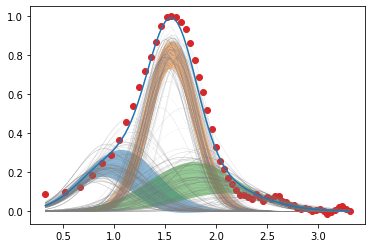

In [126]:
numbers = len(fitResult.df['means'][0])
components = []
for i in np.arange(numbers):
    t = tuple()
    t = (i,[])
    components.append(t)
for line,line2 in zip(fitResult.df['means'],fitResult.df['yfits']):
    #print(line,line2)
    line,line2 = zip(*sorted(zip(line,line2.T)))
    #print(line,line2)
    for i in np.arange(numbers):
        #print(i)
        #plt.plot(xfit,line2[i],lw=0.1,alpha=0.5)
        components[i][1].append(line2[i]/np.max(np.sum(line2,axis=0)))
    #components[0].append(line2[0])
    #plt.plot(xfit,line2[1],lw=0.1,color='lightgrey',alpha=0.5)
print(len(components[0][1]))
#print(components[])
means = []
for i,line in enumerate(components):
    mean = np.mean(line[1],axis=0)
    means.append(mean)
    std = np.std(line[1],axis=0)
    #plt.plot(xfit,mean)
    plt.fill_between(xfit,mean+std,mean-std,alpha=0.5)
    ls = line[1]#/np.max(np.sum(line[1],axis=1))
    for l in ls:
        plt.plot(xfit,l,lw=0.1,alpha=0.5,color='grey')
plt.scatter(xraw,yraw)
#plt.plot(xfit,yfit)
plt.plot(xfit,sum(means))
#for line in components[0][1]:
#    plt.plot(xfit,line)
#for i in np.arange(numbers):
#    plt.plot(xfit,components[0])
#std = np.std(components[1],axis=0)
#mean = np.mean(components[1],axis=0)
#plt.plot(xfit,mean)
#plt.fill_between(xfit,mean+std,mean-std,alpha=0.5)

In [123]:
components[0][1]

[array([2.48250007e-02, 3.08837867e-02, 3.81165089e-02, 4.66699125e-02,
        5.66894385e-02, 6.83138279e-02, 8.16688397e-02, 9.68602191e-02,
        1.13966132e-01, 1.33029349e-01, 1.54049545e-01, 1.76976122e-01,
        2.01702009e-01, 2.28058926e-01, 2.55814537e-01, 2.84671943e-01,
        3.14271797e-01, 3.44197292e-01, 3.73982075e-01, 4.03121001e-01,
        4.31083458e-01, 4.57328840e-01, 4.81323560e-01, 5.02558876e-01,
        5.20568726e-01, 5.34946680e-01, 5.45361177e-01, 5.51568223e-01,
        5.53420898e-01, 5.50875135e-01, 5.43991461e-01, 5.32932607e-01,
        5.17957113e-01, 4.99409280e-01, 4.77706018e-01, 4.53321289e-01,
        4.26768950e-01, 3.98584873e-01, 3.69309185e-01, 3.39469454e-01,
        3.09565528e-01, 2.80056581e-01, 2.51350799e-01, 2.23797925e-01,
        1.97684737e-01, 1.73233356e-01, 1.50602159e-01, 1.29888941e-01,
        1.11135920e-01, 9.43361225e-02, 7.94406688e-02, 6.63665222e-02,
        5.50042853e-02, 4.52256992e-02, 3.68905688e-02, 2.985291

array([2.54490136e-02, 3.15926351e-02, 3.89096328e-02, 4.75428045e-02,
       5.76326837e-02, 6.93121343e-02, 8.27001094e-02, 9.78947222e-02,
       1.14965850e-01, 1.33947563e-01, 1.54830729e-01, 1.77556217e-01,
       2.02009127e-01, 2.28014509e-01, 2.55335004e-01, 2.83670786e-01,
       3.12662108e-01, 3.41894625e-01, 3.70907553e-01, 3.99204533e-01,
       4.26266923e-01, 4.51569069e-01, 4.74594960e-01, 4.94855543e-01,
       5.11905906e-01, 5.25361475e-01, 5.34912429e-01, 5.40335545e-01,
       5.41502877e-01, 5.38386774e-01, 5.31060964e-01, 5.19697657e-01,
       5.04560817e-01, 4.85995968e-01, 4.64417090e-01, 4.40291299e-01,
       4.14122089e-01, 3.86431991e-01, 3.57745459e-01, 3.28572772e-01,
       2.99395587e-01, 2.70654718e-01, 2.42740471e-01, 2.15985782e-01,
       1.90662164e-01, 1.66978384e-01, 1.45081613e-01, 1.25060706e-01,
       1.06951225e-01, 9.07417248e-02, 7.63808841e-02, 6.37850227e-02,
       5.28456362e-02, 4.34366106e-02, 3.54208608e-02, 2.86562050e-02,
      

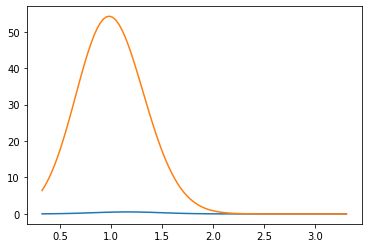

In [122]:
#np.max(np.sum(components[0][1],axis=1))
plt.plot(xfit,components[0][1][1])
plt.plot(xfit,np.sum(components[0][1],axis=0))
components[0][1][1]

In [85]:
df_rawResults = fitResult.df
numbers = 3
ycomponents = []
xmeans = []
covras = []
weightss = []
for i in np.arange(numbers):
    #t = tuple()
    t = (i,[])
    ycomponents.append(t)
    #xmeans.append(t)
    #covras.append(t)
    #weightss.append(t)
for index,row in df_rawResults.iterrows():
    #for line,line2 in zip(self.df_rawResults['means'],self.df_rawResults['yfits']):
    means = row['means'].tolist()
    yfits = row['yfits']
    means,yfits = zip(*sorted(zip(means,yfits.T)))
    means,covs = zip(*sorted(zip(means,row['covras'])))
    means,weigs = zip(*sorted(zip(means,row['weights'])))
    #print(list(means))
    for i in np.arange(numbers):
        ycomponents[i][1].append(yfits[i])
    xmeans.append(means)
    covras.append(covs)
    weightss.append(weigs)
fit_means = []
for i,line in enumerate(ycomponents):
    fit_mean = np.mean(line[1],axis=0)
    fit_means.append(fit_mean)
    std = np.std(line[1],axis=0)

xmean,covra,wieg = [],[],[]
for t in np.arange(numbers):
    xmean.append(np.mean([i[t] for i in xmeans],axis=0))
    covra.append(np.mean([i[t] for i in covras],axis=0))
    wieg.append(np.mean([i[t] for i in weightss],axis=0))
xmean

[array([0.97020959]), array([1.55916947]), array([1.93912688])]

In [92]:
np.array(fit_means).T.shape

(100, 3)

In [86]:
t=tuple()
t=(1,[])
t[1].append([1,2,3])
t

(1, [[1, 2, 3]])

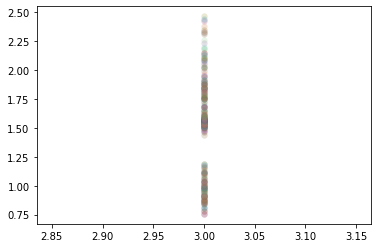

In [87]:

for line,line2 in zip(fitResult.df['means'],fitResult.df['covras']):
    plt.scatter([len(line)]*len(line),line,lw=0.1,alpha=0.1)
    #plt.scatter([len(line)+0.5]*len(line),line2[:,0],lw=0.1,color='red',alpha=0.5)

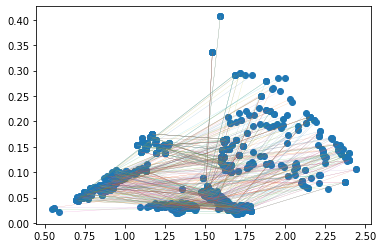

In [140]:
mean = []
std = []
for line,line2 in zip(fitResult.df['means'],fitResult.df['covras']):
    plt.plot(line,line2[:,0],lw=0.2,alpha=0.5)
    for i in np.arange(len(line)):
        mean.append(line[i][0])
        std.append(line2[i][0])
plt.scatter(mean,std)

/var/folders/db/fds4d4mj23711wt3n_g622400000gn/T/ipykernel_46432/3906080003.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(list(zip(mean/np.max(mean),std/np.max(std))))


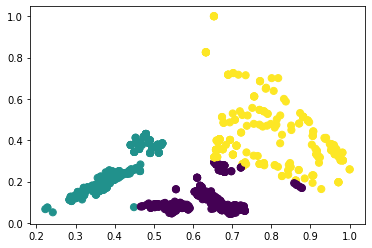

In [99]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=0):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels
X = np.array(list(zip(mean/np.max(mean),std/np.max(std))))

centers, labels = find_clusters(X, 3)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

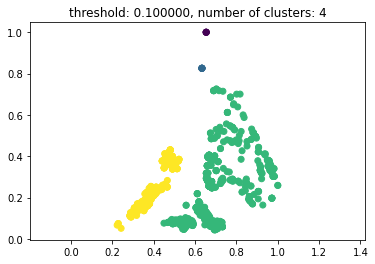

In [100]:
import scipy.cluster.hierarchy as hcluster

# generate 3 clusters of each around 100 points and one orphan point
data = X

# clustering
thresh = 0.1
clusters = hcluster.fclusterdata(data, thresh, criterion="distance")

# plotting
plt.scatter(*np.transpose(data), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
plt.title(title)
plt.show()

In [148]:

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=50,).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(db,labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print(
#    "Adjusted Mutual Information: %0.3f"
#    % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

Estimated number of clusters: 4
Estimated number of noise points: 176


TypeError: homogeneity_score() missing 1 required positional argument: 'labels_pred'